# 03 Black-Litterman Sensitivity Analysis

This notebook sweeps BL view confidence and visualizes how strategy properties change:
- Annual return
- Annual volatility
- Sharpe
- Concentration (HHI) and turnover


## Why Sensitivity Matters

Black-Litterman confidence is a critical hyperparameter.
This notebook maps how strategy behavior changes as confidence moves from low to high.

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT / "src"))

from portfolio_bl.config import load_config
from portfolio_bl.pipeline import run_case_study

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.4f}".format


In [2]:
cfg = load_config(ROOT / "configs/case_studies.yaml")
person_key = "pelosi"
confidence_grid = np.round(np.linspace(0.20, 0.95, 16), 2)

rows = []
for conf in confidence_grid:
    result = run_case_study(cfg, person_key=person_key, view_confidence=float(conf))
    metrics = result.summary.loc["black_litterman"]
    rows.append({
        "confidence": float(conf),
        "annual_return": float(metrics["annual_return"]),
        "annual_volatility": float(metrics["annual_volatility"]),
        "sharpe": float(metrics["sharpe"]),
        "hhi": float(metrics["hhi"]),
        "avg_turnover": float(metrics["avg_turnover"]),
    })

sensitivity = pd.DataFrame(rows).replace([np.inf, -np.inf], np.nan)
sensitivity.head()


,confidence,annual_return,annual_volatility,sharpe,hhi,avg_turnover
0,0.2000,0.0690,0.0061,11.3427,0.0814,0.1363
1,0.2500,0.0692,0.0062,11.1653,0.0801,0.1363
2,0.3000,0.0695,0.0063,11.0077,0.0790,0.1368
3,0.3500,0.0697,0.0064,10.8667,0.0782,0.1373
4,0.4000,0.0699,0.0065,10.7535,0.0775,0.1377


## Sensitivity Curves

Interpret these plots jointly: a higher Sharpe may come with higher concentration or turnover.

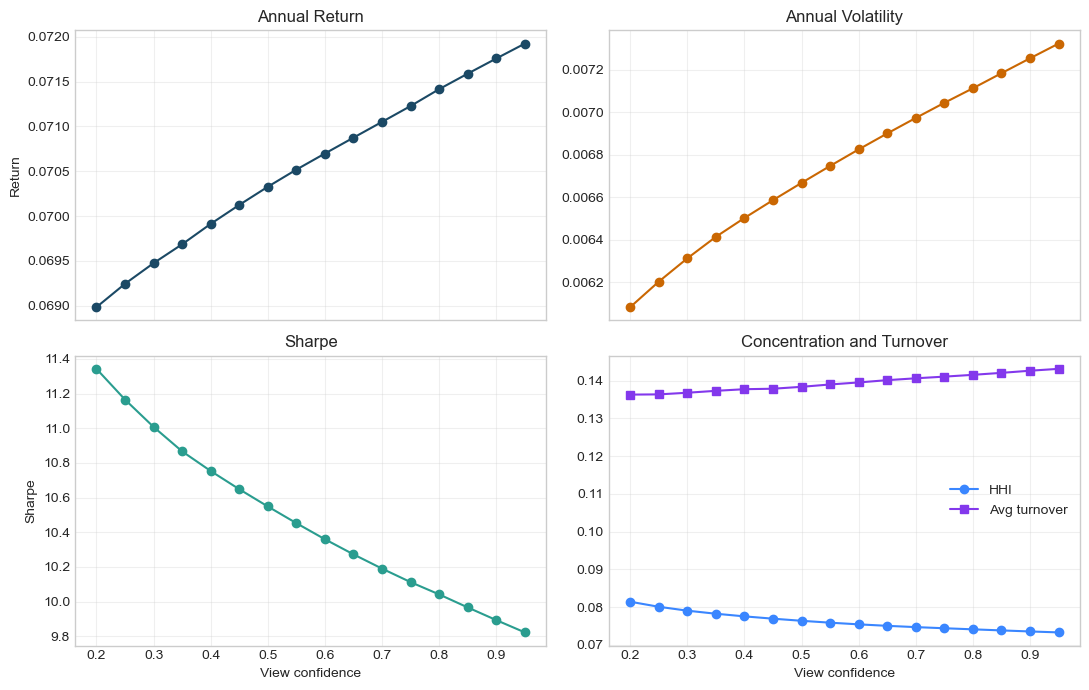

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True)

axes[0, 0].plot(sensitivity["confidence"], sensitivity["annual_return"], marker="o", color="#1B4965")
axes[0, 0].set_title("Annual Return", pad=16)
axes[0, 0].set_ylabel("Return")

axes[0, 1].plot(sensitivity["confidence"], sensitivity["annual_volatility"], marker="o", color="#CA6702")
axes[0, 1].set_title("Annual Volatility", pad=16)

axes[1, 0].plot(sensitivity["confidence"], sensitivity["sharpe"], marker="o", color="#2A9D8F")
axes[1, 0].set_title("Sharpe", pad=16)
axes[1, 0].set_xlabel("View confidence")
axes[1, 0].set_ylabel("Sharpe")

axes[1, 1].plot(sensitivity["confidence"], sensitivity["hhi"], marker="o", label="HHI", color="#3A86FF")
axes[1, 1].plot(sensitivity["confidence"], sensitivity["avg_turnover"], marker="s", label="Avg turnover", color="#8338EC")
axes[1, 1].set_title("Concentration and Turnover", pad=16)
axes[1, 1].set_xlabel("View confidence")
axes[1, 1].legend()

for ax in axes.ravel():
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Candidate Confidence Point

Use the best row as a starting point, then validate robustness around nearby values.

In [4]:
best_row = sensitivity.sort_values("sharpe", ascending=False).iloc[0]
print("Best confidence by Sharpe:")
print(best_row)


Best confidence by Sharpe:
confidence           0.2000
annual_return        0.0690
annual_volatility    0.0061
sharpe              11.3427
hhi                  0.0814
avg_turnover         0.1363
Name: 0, dtype: float64


## Notes

- On real data, this curve is often non-monotonic.
- Higher confidence tends to increase turnover if your views diverge from equilibrium returns.
- Use this notebook to pick a confidence range before final reporting.
